In [1]:
import torch, torchvision, cv2, PIL, os, random
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Dataset

In [2]:
total_train_pd = pd.read_csv(f"/home/user1/바탕화면/DACON 퍼즐/train.csv")
total_test_pd = pd.read_csv(f"/home/user1/바탕화면/DACON 퍼즐/test.csv")

In [3]:
# img_path 불러오기
pd_train_ID = total_train_pd["ID"]
pd_test_ID = total_test_pd["ID"]

# ID, img_path 제거하고 label만 남기기
pd_train_label = total_train_pd.drop(['ID', 'img_path'], axis=1)

print(f"Train_ID[0]: {pd_train_ID.iloc[0]}")

# 행 단위로 Label data 읽어오기
print(f"Train_Label[0]: {pd_train_label.iloc[0].to_numpy()}")

Train_ID[0]: TRAIN_00000
Train_Label[0]: [ 8  1 16 12  5 10 14  2 13  4  7  3  6  9 11 15]


In [4]:
def label_to_numpy(total_label):
    length = len(total_label)
    label = []

    for i in range(length):
        label.append(total_label.iloc[i].to_numpy())
    
    return np.array(label)

In [5]:
train_label = label_to_numpy(pd_train_label)
print(f"TRAIN_LABEL_SIZE: {train_label.shape}")

TRAIN_LABEL_SIZE: (70000, 16)


In [6]:
def img_path_list(ID, train):
    path = f"/home/user1/바탕화면/DACON 퍼즐/"
    img_path = []
    size = len(ID)

    if train is True:
        path = f"{path}train/"
        for i in range(size):
            img_path.append(f"{path}{ID[i]}.jpg")
    else:
        path = f"{path}test/"
        for i in range(size):
            img_path.append(f"{path}{ID[i]}.jpg")
    
    return img_path

In [7]:
train_img_path = img_path_list(pd_train_ID, True)
print(f"No. of TRAIN IMAGES: {len(train_img_path)}")
print(f"TRAIN_IMG_PATH[0]: {train_img_path[0]}")

No. of TRAIN IMAGES: 70000
TRAIN_IMG_PATH[0]: /home/user1/바탕화면/DACON 퍼즐/train/TRAIN_00000.jpg


In [8]:
resizing = transforms.Resize((224, 224))

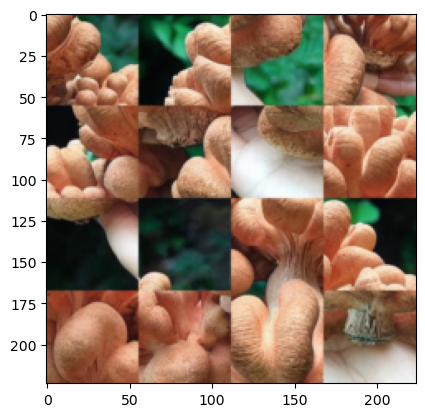

In [9]:
# Sample 이미지 -> TRAIN_00000
sample = PIL.Image.open(train_img_path[0])
resized = resizing(sample)
plt.imshow(resized)

In [10]:
print(sample.size)

(512, 512)


In [11]:
# GRID: 4x4/3x3/2x2 -> 몇 by 몇의 퍼즐인가?
def split_image(img, grid):
    orig_img = np.array(img)
    size = len(orig_img)
    grid_size = int(size/grid)
    results = []
    
    for i in range(grid):
        for j in range(grid):
            results.append(orig_img[grid_size*i:grid_size*(i+1), grid_size*j:grid_size*(j+1)])
    
    return results

In [12]:
x = torch.randn(8, 3, 224, 224)  # (batch, channel, height, width)

patch_size = 16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
patches.shape
# batch = 8
# 각 patch는 768차원을 갖는 1D vector
# 위와 같은 patch가 총 196개

torch.Size([8, 196, 768])

In [13]:
# Linear Projection 대신 Convolutional Layer 사용 -> Better performance
projection = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=768, kernel_size=16, stride=16),
    Rearrange('b e (h) (w) -> b (h w) e')
)

projection(x).shape

torch.Size([8, 196, 768])

In [14]:
emb_size = 768
img_size = 224
patch_size = 16

projected_x = projection(x)
print(projected_x.shape)

cls_token = nn.Parameter(torch.randn(1,1,emb_size))  # nn.Parameter 함수는 무슨 함수인지?
positions = nn.Parameter(torch.randn((img_size//patch_size)**2+1, emb_size))  # Position embedding은 cls tkn포함 -> +1
print(cls_token.shape, positions.shape)

batch_size = 8
cls_tokens = repeat(cls_token, '() n e -> b n e', b=batch_size)  # n, e는 각각 무엇을 대표하는지?
print(cls_tokens.shape)

cat_x = torch.cat([cls_tokens, projected_x], dim=1)

cat_x += positions
print(cat_x.shape)
#  [8, 196, 768]
# +[8,   1, 768] (dim=1)

torch.Size([8, 196, 768])
torch.Size([1, 1, 768]) torch.Size([197, 768])
torch.Size([8, 1, 768])
torch.Size([8, 197, 768])


In [15]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=768, kernel_size=16, stride=16),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        self.positions = nn.Parameter(torch.randn((img_size//patch_size)**2+1, emb_size))
    
    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        
        return x

In [16]:
# 1D Vector로 Embedding된 각각의 patch들을 다시 embedding size로 linear projection
# 각 layer는 Training 과정에서 학습된다
queries = nn.Linear(768, 768)
keys = nn.Linear(768, 768)
values = nn.Linear(768, 768)

In [17]:
queries = rearrange(queries(cat_x), 'b n (h d) -> b h n d', h=8)  # cat_x가 아니라 projected_x가 들어가야 하지 않나?
keys = rearrange(keys(cat_x), 'b n (h d) -> b h n d', h=8)        # cat_x는 cls_tkn이 포함된 벡터인데
values = rearrange(values(cat_x), 'b n (h d) -> b h n d', h=8)    # cls_tkn은 전체 sequence의 임베딩 이후에 포함되어야 하지 않나?
print(queries.shape, keys.shape, values.shape)

torch.Size([8, 8, 197, 96]) torch.Size([8, 8, 197, 96]) torch.Size([8, 8, 197, 96])


In [18]:
energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
print(energy.shape)

scaling = emb_size**(1/2)
att = F.softmax(energy, dim=-1)/scaling
print(att.shape)

out = torch.einsum('bhal, bhlv -> bhav', att, values)
print(out.shape)

out = rearrange(out, 'b h n d -> b n (h d)')
print(out.shape)

torch.Size([8, 8, 197, 197])
torch.Size([8, 8, 197, 197])
torch.Size([8, 8, 197, 96])
torch.Size([8, 197, 768])


In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, dropout=0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size*3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
    
    def forward(self, x, mask=None):
        qkv = rearrange(self.qkv(x), 'b n (h d qkv) -> (qkv) b h n d', h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        energy = torch.einsum('bgqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        
        scaling = self.emb_size**(1/2)
        att = F.softmax(energy, dim=-1)/scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav', att, values)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)

        return out

In [20]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        
        return x

In [21]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion=4, drop_p=0):
        super().__init__(
            nn.Linear(emb_size, expansion*emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion*emb_size, emb_size)
        )

In [22]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size=768, drop_p=0, forward_expansion=4, forward_drop_p=0, **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
        )

In [23]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([8, 197, 768])

In [24]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [25]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=768, n_classes=1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

In [26]:
class ViT(nn.Sequential):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224, depth=12, n_classes=16, **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [27]:
from torchsummary import summary

summary(ViT(), (3, 224, 224), device='cpu')

TypeError: __init__() takes from 1 to 2 positional arguments but 3 were given